In [10]:
# Import all required toolkits
import glob
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sn

# Cleaning

In [20]:
from sklearn.utils import shuffle

# Read all files in a given subfolder as a labelled dataframe
def readFiles (path, label):
    reviews = [open(filename, 'r', encoding='utf-8').read() for filename in glob.glob('aclImdb/' + path + '/*.txt')]
    return pd.DataFrame({ 'label': label, 'review': reviews })

# Read train dataset and shuffle data to avoid having all positive first then negative ones
train_data = shuffle(pd.concat([
    readFiles('train/pos', 'positive'),
    readFiles('train/neg', 'negative')
]))
train_data.head()

,label,review
5349,negative,Stephen King is generally known for the morbid...
11488,positive,"""Hollywood Hotel"" is a fast-moving, exuberant,..."
9439,negative,Gwyneth Paltrow is absolutely great in this mo...
3046,negative,Rented a batch of films from Blockbuster last ...
2645,positive,"A young woman who is a successful model, and i..."


In [23]:
# Read test dataset
test_data = shuffle(pd.concat([
    readFiles('test/pos', 'positive'),
    readFiles('test/neg', 'negative')
]))
test_data.head()

,label,review
6639,negative,This is another notorious Mexican horror film:...
7683,positive,"<br /><br />Giorgino is a strange, dark, obses..."
5608,negative,Awkward disaster mishmash has a team of scaven...
3235,positive,"You can take the crook out of the joint, but i..."
2514,negative,I'm not prone to ranting and my expectations w...


In [24]:
# Retrieve English stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
# Create regex to filter html tags if any
html_regex = re.compile('<.*?>')
# Create stemmer
stemmer = nltk.PorterStemmer()
# Create lemmatizer
nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()

# Perform the clean up process on an input dataset
def clean (data):
    print('Processing started')
    # 1. Remove html tags
    print('Removing tags', end='...')
    data['review_processed'] = data['review'].apply(lambda x: re.sub(html_regex, ' ', x))
    print('OK')
    # 2. Remove punctuation
    print('Removing punctuation', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    print('OK')
    # 3. Tokenize
    print('Tokenizing', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: re.split('\W+', x.lower()))
    print('OK')
    # 4. Remove stop words
    print('Removing stop words', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: [word for word in x if word not in stopwords])
    print('OK')
    # 5. Apply stemming or lemmatization
    print('Stemming', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: [stemmer.stem(word) for word in x])
    #print('Lemmatization', end='...')
    #data['review_processed'] = data['review_processed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    print('OK')
    # 6. Replace input data with processed data
    data.drop(columns=['review'], axis=1, inplace=True)
    data.rename(columns={'review_processed': 'review'}, inplace=True)
    print('Processing finished')
    
# Process train dataset
clean(train_data)
train_data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luccl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luccl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing started
Removing tags...OK
Removing punctuation...OK
Tokenizing...OK
Removing stop words...OK
Stemming...OK
Processing finished


,label,review
5349,negative,"[stephen, king, gener, known, morbid, that, fi..."
11488,positive,"[hollywood, hotel, fastmov, exuber, wonder, en..."
9439,negative,"[gwyneth, paltrow, absolut, great, movi, stori..."
3046,negative,"[rent, batch, film, blockbust, last, night, fi..."
2645,positive,"[young, woman, success, model, also, engag, ma..."


In [25]:
# Process test dataset
clean(test_data)
test_data.head()

Processing started
Removing tags...OK
Removing punctuation...OK
Tokenizing...OK
Removing stop words...OK
Stemming...OK
Processing finished


,label,review
6639,negative,"[anoth, notori, mexican, horror, film, howev, ..."
7683,positive,"[, giorgino, strang, dark, obsess, object, cas..."
5608,negative,"[awkward, disast, mishmash, team, scaveng, com..."
3235,positive,"[take, crook, joint, seem, exceedingli, diffic..."
2514,negative,"[im, prone, rant, expect, low, start, seem, li..."


In [26]:
# Save processed data so that we can skip previous steps and start over from next step
# when we are satisfied enough with our preprocessing
# SKIP if already saved
print('Saving test data', end='...')
test_data.to_pickle('test_data.pkl')
print('OK:', test_data.shape)
print('Saving train data', end='...')
train_data.to_pickle('train_data.pkl')
print('OK:', train_data.shape)

Saving test data...OK: (25000, 2)
Saving train data...OK: (25000, 2)


In [41]:
# Load processed data
# SKIP if already loaded
print('Loading test data', end='...')
test_data = pd.read_pickle('test_data.pkl')
print('OK', test_data.shape)
print('Loading train data', end='...')
train_data = pd.read_pickle('train_data.pkl')
print('OK', train_data.shape)

Loading test data...OK (25000, 2)
Loading train data...OK (25000, 2)


In [28]:
# Simplify data for testing purpose
# SKIP to handle all data
test_data = test_data.head(100)
train_data = test_data.head(100)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
# We can select the most important features (ie words) using term frequency-inverse document frequency method
# Vectorizer expect strings as it performs tokenization by default
# As we already have tokens we override the default analyzer
vectorizer = TfidfVectorizer(analyzer=lambda x: x, max_features=50)
train_tfidf = vectorizer.fit_transform(train_data['review'])
print(dict(zip(vectorizer.get_feature_names(), vectorizer.idf_)))
# Filter words according to feature selection in reviews if we'd like
#train_data['review'] = train_data['review'].apply(lambda x: [word for word in x if word in vectorizer.get_feature_names()])

{'act': 2.3408257650891464, 'actor': 2.6266240704690924, 'also': 2.3778901135372488, 'bad': 2.472502456607044, 'charact': 2.121757161583228, 'come': 2.5762365778543197, 'could': 2.4533292291441904, 'dont': 2.3956576877807962, 'end': 2.3471136471666307, 'even': 2.090684118218954, 'film': 1.5333157518036038, 'first': 2.3919500991055473, 'get': 2.0271505661794205, 'go': 2.3431216258970933, 'good': 1.9677292941601767, 'great': 2.3856945650325727, 'know': 2.5158054357714867, 'like': 1.7072861041394685, 'littl': 2.6478030259557896, 'look': 2.3186009482858214, 'love': 2.464685166732581, 'made': 2.405231797424375, 'make': 1.9705757459265723, 'mani': 2.6048884593003145, 'movi': 1.4458896975036615, 'much': 2.278018216836453, 'never': 2.615294796955687, 'one': 1.5821468249709758, 'peopl': 2.399216986150926, 'play': 2.49383048810816, 'plot': 2.5997256201914434, 'realli': 2.192347771995454, 'say': 2.5121697291671237, 'scene': 2.3621491935315566, 'see': 1.9984088421097832, 'seem': 2.577204351083826,

# Exploration

Counting words...OK
Counting words...OK
Counting words...OK
Counting words...OK


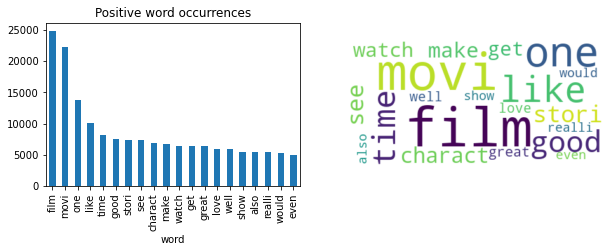

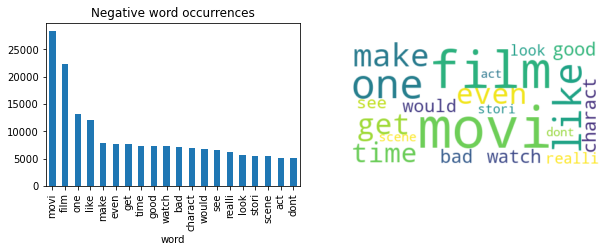

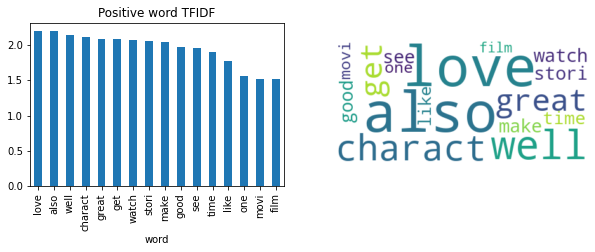

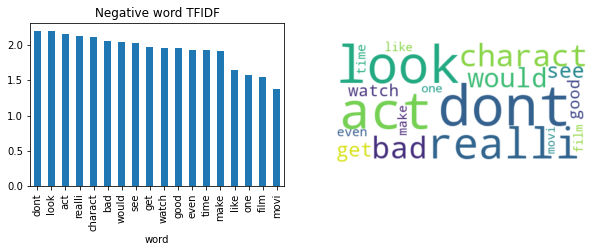

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Perform a full vectorization of labelled data
def words2frequency (data, tfidf=False):
    print('Counting words', end='...')
    # Count occurences or term frequency-inverse document frequency
    if (tfidf == False):
        vectorizer = CountVectorizer(analyzer=lambda x: x)
        counts = vectorizer.fit_transform(data['review'])
        # Create a data frame to handle word occurrences
        frequencies = pd.DataFrame({'word': vectorizer.get_feature_names(), 'frequency': counts.toarray().sum(axis=0)})
    else:
        vectorizer = TfidfVectorizer(analyzer=lambda x: x, max_df=0.75, min_df=0.3, max_features=20)
        counts = vectorizer.fit_transform(data['review'])
        # Create a data frame to handle word frequencies
        frequencies = pd.DataFrame({'word': vectorizer.get_feature_names(), 'frequency': vectorizer.idf_})
    frequencies.sort_values(by=['frequency'], ascending=False, inplace=True)
    print('OK')
    return frequencies

# Display a distribution plot and a word cloud
def display_frequency (frequencies, title):
    figure, axes = plt.subplots(1, 2, figsize=(10,3))
    frequencies.plot(x='word', y='frequency', kind='bar', legend=False, subplots=True, ax=axes[0], sharex=False, sharey=False)
    axes[0].title.set_text(title)
    wordcloud = WordCloud(background_color='white').fit_words(dict(frequencies.values.tolist()))
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].axis("off")

# Display statistics about N most used words in positive/negative reviews using occurrences counting
positive_frequencies = words2frequency(train_data[train_data['label'] == 'positive'])
display_frequency(positive_frequencies.head(20), 'Positive word occurrences')
negative_frequencies = words2frequency(train_data[train_data['label'] == 'negative'])
display_frequency(negative_frequencies.head(20), 'Negative word occurrences')
# Then using TFIDF as feature selector
positive_frequencies = words2frequency(train_data[train_data['label'] == 'positive'], tfidf=True)
display_frequency(positive_frequencies.head(20), 'Positive word TFIDF')
negative_frequencies = words2frequency(train_data[train_data['label'] == 'negative'], tfidf=True)
display_frequency(negative_frequencies.head(20), 'Negative word TFIDF')


It appears that raw word occurrences does not give much information to easily separate negative and positive reviews. For instance, the most used words in both cases are *film, movie, one*, etc. which are more related to the context of reviewing than the sentiment of the reviewer. When performing feature engineering it seems to provide better discriminants. For instance we can see *love, well, great, good* words for positive reviews and *don't, bad* words for negative ones, which are more related to the author sentiment. Moreover, the negative reviews seem to focus on *act(ion)* movies while the positive ones might focus on *love (stories)*. 